In [28]:
import warnings
warnings.filterwarnings("ignore")

# Importing the necessary libraries 

In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Data Loading 

In [30]:
train = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val = "/kaggle/input/chest-xray-pneumonia//chest_xray/val"
test = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Data Preprocessing 

In [31]:
input_shape = (224, 224, 3)
np.random.seed(42)
tf.random.set_seed(42)
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = datagen.flow_from_directory(
    train,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_directory(
    val,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    test,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model Building 

In [32]:
# Create a CNN model for anomaly detection
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training 

In [36]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
163/163 [==============================] - 63s 373ms/step - loss: 1.4704 - accuracy: 0.7080 - val_loss: 0.6996 - val_accuracy: 0.7308
Epoch 2/10
163/163 [==============================] - 60s 364ms/step - loss: 0.3697 - accuracy: 0.8194 - val_loss: 0.6358 - val_accuracy: 0.7676
Epoch 3/10
163/163 [==============================] - 60s 366ms/step - loss: 0.2756 - accuracy: 0.8706 - val_loss: 0.7621 - val_accuracy: 0.7692
Epoch 4/10
163/163 [==============================] - 61s 371ms/step - loss: 0.2006 - accuracy: 0.9036 - val_loss: 0.6933 - val_accuracy: 0.7885
Epoch 5/10
163/163 [==============================] - 61s 372ms/step - loss: 0.1547 - accuracy: 0.9248 - val_loss: 1.6012 - val_accuracy: 0.6715


# Plotting the accuracies

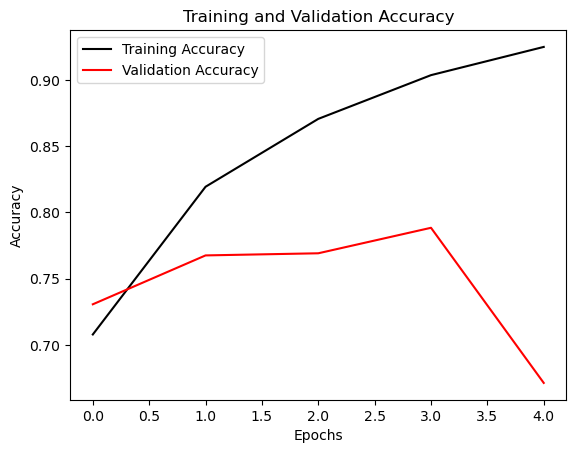

In [37]:
#import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='k')
plt.plot(history.
         history['val_accuracy'], label='Validation Accuracy', color='r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

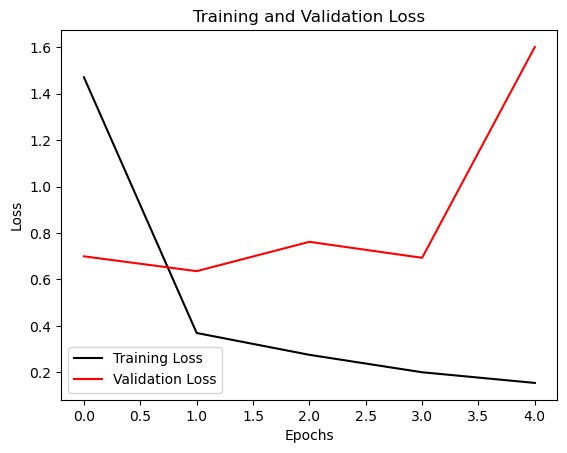

In [38]:
plt.plot(history.history['loss'], label='Training Loss', color='k')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Model Structure 

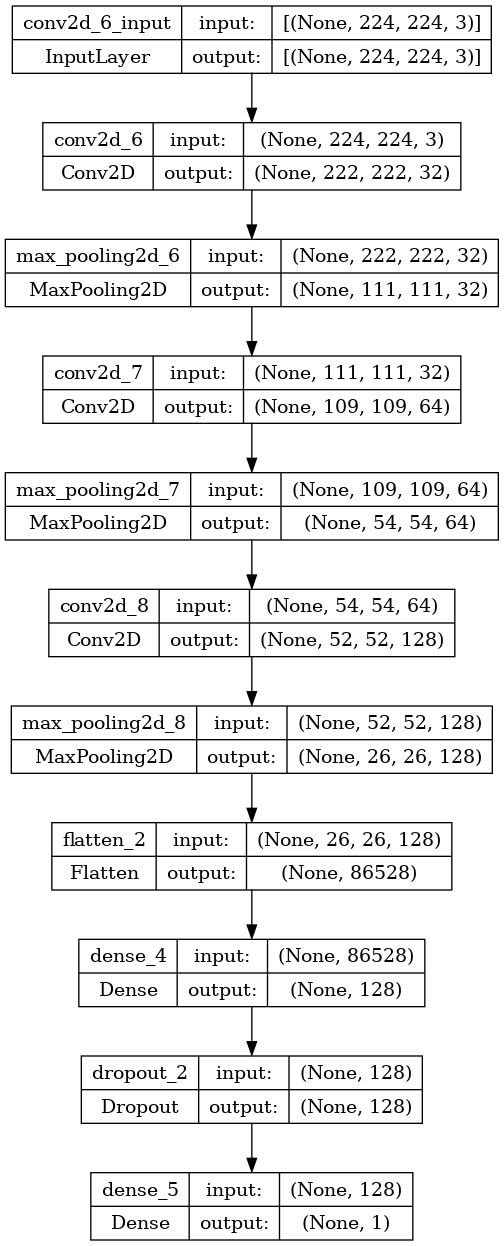

In [39]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [40]:
model.save("anamoly_detect.h5")

In [41]:
# Predict anomaly scores for the test images
anomaly_scores = model.predict(val_generator)

16/16 [==============================] - 0s 10ms/step


# Classification of the images 

In [42]:
# Define a threshold for anomaly detection
threshold = 0.5

# Classify the test images as normal or anomalous based on the threshold
for i, score in enumerate(anomaly_scores):
    if score < threshold:
        classification = 'Normal'
        normal_image = val_generator[i][0][0] * 255.0  # Retrieve a normally classified image
        break

for i, score in enumerate(anomaly_scores):
    if score >= threshold:
        classification = 'Anomalous'
        anomalous_image = val_generator[i][0][0] * 255.0  # Retrieve an anomalous image
        break

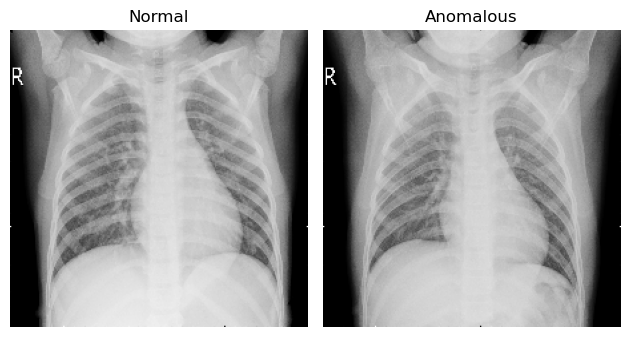

In [43]:
# Display the images and their classifications
plt.subplot(1, 2, 1)
plt.imshow(normal_image.astype(np.uint8))
plt.title('Normal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(anomalous_image.astype(np.uint8))
plt.title('Anomalous')
plt.axis('off')

plt.tight_layout()
plt.show()
